<a href="https://colab.research.google.com/github/katha815/ADME-Classifier/blob/main/Different_ML_models_Box_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance, (4){A-C,A-G,A-T,C-A,...}categorical input, (5)Ensemble search consequence , (6)corresponding SIFT and Polyphen scores, (7) popoulation frequencies.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
!pip install scikit-optimize
import skopt
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skopt.space import Real, Categorical, Integer

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install numba
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/lib/python3.10/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.8/nvvm/libdevice
find: ‘/proc/61/task/61/net’: Invalid argument
find: ‘/proc/61/net’: Invalid argument
/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so
find: ‘/proc/61/task/61/net’: Invalid argument
find: ‘/proc/61/net’: Invalid argument


In [ ]:
import math
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

## Data loading and testing/training split preparation

###Odata

In [ ]:
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/Odata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {data2}\n")
Y = data2['Label']
X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
           col!="chr" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(Y,'\n')

Whole data:     Chromo  Location1  Location2 Ref Alter  Label  chr  transcript_ablation  \
0     chr1   46930150   46930150   C     T      1    1                    0   
1     chr1   46930161   46930161   G     A      1    1                    0   
2     chr1   46932824   46932824   T     C      1    1                    0   
3     chr1   46932987   46932987   C     T      1    1                    0   
4     chr1   46934207   46934207   A     G      0    1                    0   
..     ...        ...        ...  ..   ...    ...  ...                  ...   
329  chr22   42129836   42129836   C     T      0   22                    0   
330  chr22   42130692   42130692   C     T      1   22                    0   
331  chr22   42130710   42130710   C     T      0   22                    0   
332  chr22   42130715   42130715   G     A      1   22                    0   
333  chr22   42130761   42130761   G     A      1   22                    0   

     splice_acceptor_variant  splice_do

In [ ]:
## Prepare leave one chromosome out split indexes
chrom_values = X['Chromo'].unique()
grouped = X.groupby(['Chromo'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist = [None for _ in range(chrom_values.shape[0])]
trainlist = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist[i])}\n")
    print(f"Test indexes: {testlist[i]}\n")
    # Label: {labels[i]}\n {type(testlist[i])}\n")

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist)) < 20 and len(testlist) > 1:
    idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
    print(testlist[idx1], testlist[idx2])
    testlist[idx1] = testlist[idx1] + testlist[idx2]
    testlist.pop(idx2)
# Check merged-testing sets length:
for x in testlist:
    print(f"Test size: {len(x)};")

# Validation list: order = order+1 for the testlist
vlist = testlist[1:] + [testlist[0]]
for x in vlist:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(X)))
# print(all)
trainlist = []
for i, test_indexes in enumerate(testlist):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist.append(train_indexes)
for x in trainlist:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist[i])}\n")
    # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (18,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Chromosome: chr1:
Data_size: 18
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Chromosome: chr2:
Data_size: 28
Test indexes: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Chromosome: chr3:
Data_size: 8
Test indexes: [46, 47, 48, 49, 50, 51, 52, 53]

Chromosome: chr4:
Data_size: 8
Test indexes: [54, 55, 56, 57, 58, 59, 60, 61]

Chromosome: chr6:
Data_size: 42
Test indexes: [62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]

Chromosome: chr7:
Data_size: 11
Test indexes: [104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]

Chromosome: chr8:
Data_size: 29
Test indexes: [115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,

In [ ]:
updated_trainlist = []
for i, test_indexes in enumerate(trainlist):
    v_indexes = vlist[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist.append(updated_test_indexes)
for x in updated_trainlist:
    print(f"Train size: {len(x)};")

Train size: 264;
Train size: 263;
Train size: 276;
Train size: 218;
Train size: 227;
Train size: 280;
Train size: 270;
Train size: 269;
Train size: 271;


In [ ]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
X = X.drop('Chromo', axis=1)
X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

###GKBdata

In [ ]:
# Import data
gkb = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/GKBdata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {gkb}\n")
gkb_Y = gkb['Label']
gkb_X = gkb[[col for col in gkb.columns if col!="Location1" and col!="Location2" and
           col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(gkb_X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(gkb_X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(gkb_Y,'\n')

Whole data:      chr  Location1 Ref Alter  transcript_ablation  splice_acceptor_variant  \
0      1   97057448   G     A                    0                        0   
1      1   97073844   G     A                    0                        0   
2      1   97077914   T     C                    0                        0   
3      1   97078076   A     G                    0                        0   
4      1   97078196   G     A                    0                        0   
..   ...        ...  ..   ...                  ...                      ...   
695   22   42129033   C     T                    0                        0   
696   22   42130692   G     A                    0                        0   
697   22   42130718   C     T                    0                        0   
698   22   42131289   G     T                    0                        0   
699   22   42132375   G     C                    0                        0   

     splice_donor_variant  stop_gained 

In [ ]:
## Prepare leave one chromosome out split indexes
chrom_values = gkb_X['chr'].unique()
grouped = gkb_X.groupby(['chr'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist2 = [None for _ in range(chrom_values.shape[0])]
trainlist2 = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist2[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist2[i])}\n")
    print(f"Test indexes: {testlist2[i]}\n")
    # Label: {labels[i]}\n {type(testlist2[i])}\n")

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist2)) < 20 and len(testlist2) > 1:
    idx1, idx2 = sorted(range(len(testlist2)), key=lambda i: len(testlist2[i]))[:2] #not including 2, so 0/1
    print(testlist2[idx1], testlist2[idx2])
    testlist2[idx1] = testlist2[idx1] + testlist2[idx2]
    testlist2.pop(idx2)
# Check merged-testing sets length:
for x in testlist2:
    print(f"Test size: {len(x)};")

# Validation list: order = order+1 for the testlist2
vlist2 = testlist2[1:] + [testlist2[0]]
for x in vlist2:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(gkb_X)))
# print(all)
trainlist2 = []
for i, test_indexes in enumerate(testlist2):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist2.append(train_indexes)
for x in trainlist2:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist2[i])}\n")
    # print(f"Train indexes: {trainlist2[i]}\n {type(trainlist2[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (136,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357]
Chromosome: 1:
Data_size: 136
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84

In [ ]:
updated_trainlist2 = []
for i, test_indexes in enumerate(trainlist2):
    v_indexes = vlist2[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist2.append(updated_test_indexes)
for x in updated_trainlist2:
    print(f"Train size: {len(x)};")

Train size: 502;
Train size: 587;
Train size: 566;
Train size: 586;
Train size: 548;
Train size: 542;
Train size: 625;
Train size: 631;
Train size: 599;
Train size: 590;
Train size: 524;


In [ ]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
gkb_X = gkb_X.drop('chr', axis=1)
gkb_X = np.array([gkb_X.values.tolist()]).reshape(gkb_X.shape[0],-1)
gkb_Y = np.array([gkb_Y.values.tolist()]).reshape(gkb_X.shape[0],)
scaler = StandardScaler()
gkb_X = scaler.fit_transform(gkb_X)

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

## Dummy Models

*DummyClassifier* makes predictions that ignore the input features.
0. Default setting: class sklearn.dummy.DummyClassifier(*, strategy='prior', random_state=None, constant=None)

This classifier serves as a simple baseline to compare against other more complex classifiers.

The specific behavior of the baseline is selected with the strategy parameter.

1. strategy{“most_frequent”, “prior”, “stratified”, “uniform”, “constant”}, default=”prior”
Strategy to use to generate predictions.

“most_frequent”: the predict method always returns the most frequent class label in the observed y argument passed to fit. The predict_proba method returns the matching one-hot encoded vector.

“prior”: the predict method always returns the most frequent class label in the observed y argument passed to fit (like “most_frequent”). predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution.

“stratified”: the predict_proba method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The predict method returns the class label which got probability one in the one-hot vector of predict_proba. Each sampled row of both methods is therefore independent and identically distributed.

“uniform”: generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.

“constant”: always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class.

2. score(X, y, sample_weight=None)[source]
Return the mean accuracy on the given test data and labels.

### Odata

####Trial

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.5714285714285714

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.5714285714285714

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.39285714285714285

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.39285714285714285

####LOCO

In [ ]:
# Dummy Classifier LOCO - prior
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in trainlist[i]], [X[i] for i in testlist[i]]
 y_train1, y_test1 = [Y[i] for i in trainlist[i]], [Y[i] for i in testlist[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="prior")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_prior_loco = np.mean(acc_l)
acc_w_dy_prior_loco = accuracy_score(y_true, y_pred1)
auc_dy_prior_loco = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_prior_loco))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_prior_loco))
print("Model AUC_ROC: {:.4f}".format(auc_dy_prior_loco))

Average Accuray: 53.83%
Whole Accuray: 55.99%
Model AUC_ROC: 0.5000


In [ ]:
# Dummy Classifier LOCO - stratified

acc_dy_stratified_loco=[]
acc_w_dy_stratified_loco=[]
auc_dy_stratified_loco=[]

for r in range(20):
  y_true, y_pred1 = list(), list()
  acc_l = []
  n = 1
  for i in range(len(testlist)):
    #print('Left chrom: ', labels[i], '\n')
    # split data
    X_train1, X_test1 = [X[n] for n in trainlist[i]], [X[n] for n in testlist[i]]
    y_train1, y_test1 = [Y[n] for n in trainlist[i]], [Y[n] for n in testlist[i]]
    #  print(f"Iteration {n}\n")
    #print('Train: ', X_train1, '\n')
    #print('Test: ', X_test1, '\n')
    # fit model
    dummy_clf = DummyClassifier(strategy="stratified",random_state=r)
    dummy_clf.fit(X_train1, y_train1)
    # evaluate model
    yhat = dummy_clf.predict(X_test1)
    #print('True y: ', y_test1, '\n')
    #print('Estimated y: ', yhat, '\n')
    acc = accuracy_score(y_test1, yhat)
    #  print('Iteration accruacy: ', acc, '\n')
    acc_l.append(acc)
    # store
    y_true.append(y_test1)
    y_pred1.append(yhat)
    n+=1
    # Check results
    #print('True y all: ', y_true, '\n')
    #print('Estimated y all: ', y_pred1, '\n')
  y_true = np.concatenate(y_true)
  y_pred1 = np.concatenate(y_pred1)
  #print('True y all: ', y_true, '\n')
  #print('Estimated y all: ', y_pred1, '\n')
  #print('Prediction size: ', y_pred1.shape, '\n')
  # calculate accuracy
  acc_dy_stratified_loco.append(np.mean(acc_l))
  acc_w_dy_stratified_loco.append(accuracy_score(y_true, y_pred1))
  auc_dy_stratified_loco.append(roc_auc_score(y_true, y_pred1))

acc = np.mean(acc_dy_stratified_loco)
acc_w = np.mean(acc_w_dy_stratified_loco)
auc = np.mean(auc_dy_stratified_loco)
print("Average Accuray: {:.2f}%".format(100*acc))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("Model AUC_ROC: {:.4f}".format(auc))
print(acc_w_dy_stratified_loco)

Average Accuray: 49.93%
Whole Accuray: 50.22%
Model AUC_ROC: 0.4925
[0.4940119760479042, 0.5269461077844312, 0.5389221556886228, 0.48502994011976047, 0.5179640718562875, 0.4820359281437126, 0.5059880239520959, 0.4431137724550898, 0.5389221556886228, 0.5359281437125748, 0.5269461077844312, 0.48502994011976047, 0.47904191616766467, 0.4820359281437126, 0.4880239520958084, 0.5449101796407185, 0.4820359281437126, 0.49101796407185627, 0.49101796407185627, 0.5059880239520959]


In [ ]:
# Dummy Classifier LOCO - uniform
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in trainlist[i]], [X[i] for i in testlist[i]]
 y_train1, y_test1 = [Y[i] for i in trainlist[i]], [Y[i] for i in testlist[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="uniform")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_uni_loco = np.mean(acc_l)
acc_w_dy_uni_loco = accuracy_score(y_true, y_pred1)
auc_dy_uni_loco = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_uni_loco))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_uni_loco))
print("Model AUC_ROC: {:.4f}".format(auc_dy_uni_loco))

Average Accuray: 49.60%
Whole Accuray: 50.30%
Model AUC_ROC: 0.5016


In [ ]:
# Dummy Classifier LOCO - most_frequent - same with "prior"
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in trainlist[i]], [X[i] for i in testlist[i]]
 y_train1, y_test1 = [Y[i] for i in trainlist[i]], [Y[i] for i in testlist[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="most_frequent")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_fre_loco = np.mean(acc_l)
acc_w_dy_fre_loco = accuracy_score(y_true, y_pred1)
auc_dy_fre_loco = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_fre_loco))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_fre_loco))
print("Model AUC_ROC: {:.4f}".format(auc_dy_fre_loco))

Average Accuray: 53.83%
Whole Accuray: 55.99%
Model AUC_ROC: 0.5000


#### K-fold testing

In [ ]:
# Rebuild testing folds by KFold split
k = len(testlist) #same fold number with LOCO
from sklearn.model_selection import KFold
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
testlist = []
trainlist = []
for train_indexes, test_indexes in kfold.split(X):
    testlist.append(test_indexes)
    trainlist.append(train_indexes)

vlist = testlist[1:] + [testlist[0]]

for i in range(len(testlist)):
    print(f"Training set: {len(vlist[i])}, {vlist[i][0]};")
    print(f"Testing set: {len(testlist[i])}, {testlist[i][0]};")
    print(f"Validation set: {len(trainlist[i])};")

Training set: 37, 3;
Testing set: 38, 5;
Validation set: 296;
Training set: 37, 6;
Testing set: 37, 3;
Validation set: 297;
Training set: 37, 18;
Testing set: 37, 6;
Validation set: 297;
Training set: 37, 2;
Testing set: 37, 18;
Validation set: 297;
Training set: 37, 0;
Testing set: 37, 2;
Validation set: 297;
Training set: 37, 4;
Testing set: 37, 0;
Validation set: 297;
Training set: 37, 1;
Testing set: 37, 4;
Validation set: 297;
Training set: 37, 20;
Testing set: 37, 1;
Validation set: 297;
Training set: 38, 5;
Testing set: 37, 20;
Validation set: 297;


In [ ]:
# Dummy Classifier K - prior
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[n] for n in trainlist[i]], [X[n] for n in testlist[i]]
 y_train1, y_test1 = [Y[n] for n in trainlist[i]], [Y[n] for n in testlist[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="prior")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_prior_k = np.mean(acc_l)
acc_w_dy_prior_k = accuracy_score(y_true, y_pred1)
auc_dy_prior_k = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_prior_k))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_prior_k))
print("Model AUC_ROC: {:.4f}".format(auc_dy_prior_k))

Average Accuray: 56.02%
Whole Accuray: 55.99%
Model AUC_ROC: 0.5000


In [ ]:
# Dummy Classifier k - stratified

acc_dy_stratified_k=[]
acc_w_dy_stratified_k=[]
auc_dy_stratified_k=[]

for r in range(20):
  y_true, y_pred1 = list(), list()
  acc_l = []
  n = 1
  for i in range(len(testlist)):
    #print('Left chrom: ', labels[i], '\n')
    # split data
    X_train1, X_test1 = [X[n] for n in trainlist[i]], [X[n] for n in testlist[i]]
    y_train1, y_test1 = [Y[n] for n in trainlist[i]], [Y[n] for n in testlist[i]]
    #  print(f"Iteration {n}\n")
    #print('Train: ', X_train1, '\n')
    #print('Test: ', X_test1, '\n')
    # fit model
    dummy_clf = DummyClassifier(strategy="stratified",random_state=r)
    dummy_clf.fit(X_train1, y_train1)
    # evaluate model
    yhat = dummy_clf.predict(X_test1)
    #print('True y: ', y_test1, '\n')
    #print('Estimated y: ', yhat, '\n')
    acc = accuracy_score(y_test1, yhat)
    #  print('Iteration accruacy: ', acc, '\n')
    acc_l.append(acc)
    # store
    y_true.append(y_test1)
    y_pred1.append(yhat)
    n+=1
    # Check results
    #print('True y all: ', y_true, '\n')
    #print('Estimated y all: ', y_pred1, '\n')
  y_true = np.concatenate(y_true)
  y_pred1 = np.concatenate(y_pred1)
  #print('True y all: ', y_true, '\n')
  #print('Estimated y all: ', y_pred1, '\n')
  #print('Prediction size: ', y_pred1.shape, '\n')
  # calculate accuracy
  acc_dy_stratified_k.append(np.mean(acc_l))
  acc_w_dy_stratified_k.append(accuracy_score(y_true, y_pred1))
  auc_dy_stratified_k.append(roc_auc_score(y_true, y_pred1))

acc = np.mean(acc_dy_stratified_k)
acc_w = np.mean(acc_w_dy_stratified_k)
auc = np.mean(auc_dy_stratified_k)
print("Average Accuray: {:.2f}%".format(100*acc))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("Model AUC_ROC: {:.4f}".format(auc))
print(acc_w_dy_stratified_k)

Average Accuray: 50.42%
Whole Accuray: 50.42%
Model AUC_ROC: 0.4942
[0.49700598802395207, 0.5149700598802395, 0.5239520958083832, 0.4880239520958084, 0.5389221556886228, 0.4940119760479042, 0.46407185628742514, 0.5059880239520959, 0.4880239520958084, 0.4221556886227545, 0.5, 0.5419161676646707, 0.47305389221556887, 0.5538922155688623, 0.46706586826347307, 0.4311377245508982, 0.562874251497006, 0.5479041916167665, 0.48502994011976047, 0.5838323353293413]


In [ ]:
# Dummy Classifier k - uniform
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in trainlist[i]], [X[i] for i in testlist[i]]
 y_train1, y_test1 = [Y[i] for i in trainlist[i]], [Y[i] for i in testlist[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="uniform")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_uni_k = np.mean(acc_l)
acc_w_dy_uni_k = accuracy_score(y_true, y_pred1)
auc_dy_uni_k = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_uni_k))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_uni_k))
print("Model AUC_ROC: {:.4f}".format(auc_dy_uni_k))

Average Accuray: 50.58%
Whole Accuray: 50.60%
Model AUC_ROC: 0.5086


In [ ]:
# Dummy Classifier k - most_frequent - same with "prior"
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in trainlist[i]], [X[i] for i in testlist[i]]
 y_train1, y_test1 = [Y[i] for i in trainlist[i]], [Y[i] for i in testlist[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="most_frequent")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_fre_k = np.mean(acc_l)
acc_w_dy_fre_k = accuracy_score(y_true, y_pred1)
auc_dy_fre_k = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_fre_k))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_fre_k))
print("Model AUC_ROC: {:.4f}".format(auc_dy_fre_k))

Average Accuray: 56.02%
Whole Accuray: 55.99%
Model AUC_ROC: 0.5000


### GKBdata

####Trial

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.4473684210526316

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.4473684210526316

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.5526315789473685

In [ ]:
from sklearn.dummy import DummyClassifier
X_train0, X_test0 = [X[n] for n in trainlist[0]], [X[n] for n in testlist[0]]
y_train0, y_test0 = [Y[n] for n in trainlist[0]], [Y[n] for n in testlist[0]]
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train0, y_train0)
dummy_clf.predict(X_test0)
dummy_clf.score(X_test0, y_test0)
#Accuray: 67.06%

0.39473684210526316

####LOCO

In [ ]:
# Dummy Classifier LOCO - prior
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist2)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
 y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="prior")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_prior_loco2 = np.mean(acc_l)
acc_w_dy_prior_loco2 = accuracy_score(y_true, y_pred1)
auc_dy_prior_loco2 = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_prior_loco2))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_prior_loco2))
print("Model AUC_ROC: {:.4f}".format(auc_dy_prior_loco2))

Average Accuray: 49.56%
Whole Accuray: 45.57%
Model AUC_ROC: 0.4463


In [ ]:
# Dummy Classifier LOCO - stratified

acc_dy_stratified_loco2=[]
acc_w_dy_stratified_loco2=[]
auc_dy_stratified_loco2=[]

for r in range(20):
  y_true, y_pred1 = list(), list()
  acc_l = []
  n = 1
  for i in range(len(testlist2)):
    #print('Left chrom: ', labels[i], '\n')
    # split data
    X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
    y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
    #  print(f"Iteration {n}\n")
    #print('Train: ', X_train1, '\n')
    #print('Test: ', X_test1, '\n')
    # fit model
    dummy_clf = DummyClassifier(strategy="stratified",random_state=r)
    dummy_clf.fit(X_train1, y_train1)
    # evaluate model
    yhat = dummy_clf.predict(X_test1)
    #print('True y: ', y_test1, '\n')
    #print('Estimated y: ', yhat, '\n')
    acc = accuracy_score(y_test1, yhat)
    #  print('Iteration accruacy: ', acc, '\n')
    acc_l.append(acc)
    # store
    y_true.append(y_test1)
    y_pred1.append(yhat)
    n+=1
    # Check results
    #print('True y all: ', y_true, '\n')
    #print('Estimated y all: ', y_pred1, '\n')
  y_true = np.concatenate(y_true)
  y_pred1 = np.concatenate(y_pred1)
  #print('True y all: ', y_true, '\n')
  #print('Estimated y all: ', y_pred1, '\n')
  #print('Prediction size: ', y_pred1.shape, '\n')
  # calculate accuracy
  acc_dy_stratified_loco2.append(np.mean(acc_l))
  acc_w_dy_stratified_loco2.append(accuracy_score(y_true, y_pred1))
  auc_dy_stratified_loco2.append(roc_auc_score(y_true, y_pred1))

acc = np.mean(acc_dy_stratified_loco2)
acc_w = np.mean(acc_w_dy_stratified_loco2)
auc = np.mean(auc_dy_stratified_loco2)
print("Average Accuray: {:.2f}%".format(100*acc))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("Model AUC_ROC: {:.4f}".format(auc))
print(acc_w_dy_stratified_loco2)

Average Accuray: 50.46%
Whole Accuray: 49.80%
Model AUC_ROC: 0.4975
[0.49142857142857144, 0.5342857142857143, 0.46, 0.4942857142857143, 0.5085714285714286, 0.4857142857142857, 0.4857142857142857, 0.5014285714285714, 0.4857142857142857, 0.48857142857142855, 0.4714285714285714, 0.54, 0.5257142857142857, 0.47, 0.45714285714285713, 0.4757142857142857, 0.5085714285714286, 0.53, 0.49142857142857144, 0.5542857142857143]


In [ ]:
# Dummy Classifier LOCO - uniform
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist2)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
 y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="uniform")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_uni_loco2 = np.mean(acc_l)
acc_w_dy_uni_loco2 = accuracy_score(y_true, y_pred1)
auc_dy_uni_loco2 = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_uni_loco2))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_uni_loco2))
print("Model AUC_ROC: {:.4f}".format(auc_dy_uni_loco2))

Average Accuray: 50.25%
Whole Accuray: 51.29%
Model AUC_ROC: 0.5132


In [ ]:
# Dummy Classifier LOCO - most_frequent - same with "prior"
# Dummy Classifier LOCO - most_frequent
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist2)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
 y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="most_frequent")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_fre_loco2 = np.mean(acc_l)
acc_w_dy_fre_loco2 = accuracy_score(y_true, y_pred1)
auc_dy_fre_loco2 = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_fre_loco2))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_fre_loco2))
print("Model AUC_ROC: {:.4f}".format(auc_dy_fre_loco2))

Average Accuray: 49.56%
Whole Accuray: 45.57%
Model AUC_ROC: 0.4463


#### K-fold testing

In [ ]:
# Rebuild testing folds by KFold split
k = len(testlist2) #same fold number with LOCO
from sklearn.model_selection import KFold
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
testlist2 = []
trainlist2 = []
for train_indexes, test_indexes in kfold.split(gkb_X):
    testlist2.append(test_indexes)
    trainlist2.append(train_indexes)

vlist = testlist2[1:] + [testlist2[0]]

for i in range(len(testlist2)):
    print(f"Training set: {len(vlist[i])}, {vlist[i][0]};")
    print(f"Testing set: {len(testlist2[i])}, {testlist2[i][0]};")
    print(f"Validation set: {len(trainlist2[i])};")

Training set: 64, 2;
Testing set: 64, 10;
Validation set: 636;
Training set: 64, 7;
Testing set: 64, 2;
Validation set: 636;
Training set: 64, 9;
Testing set: 64, 7;
Validation set: 636;
Training set: 64, 0;
Testing set: 64, 9;
Validation set: 636;
Training set: 64, 3;
Testing set: 64, 0;
Validation set: 636;
Training set: 64, 26;
Testing set: 64, 3;
Validation set: 636;
Training set: 63, 8;
Testing set: 64, 26;
Validation set: 636;
Training set: 63, 35;
Testing set: 63, 8;
Validation set: 637;
Training set: 63, 1;
Testing set: 63, 35;
Validation set: 637;
Training set: 63, 13;
Testing set: 63, 1;
Validation set: 637;
Training set: 64, 10;
Testing set: 63, 13;
Validation set: 637;


In [ ]:
# Dummy Classifier k - prior
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist2)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
 y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="prior")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_prior_k2 = np.mean(acc_l)
acc_w_dy_prior_k2 = accuracy_score(y_true, y_pred1)
auc_dy_prior_k2 = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_prior_k2))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_prior_k2))
print("Model AUC_ROC: {:.4f}".format(auc_dy_prior_k2))

Average Accuray: 51.43%
Whole Accuray: 51.43%
Model AUC_ROC: 0.5000


In [ ]:
# Dummy Classifier k - stratified

acc_dy_stratified_k2=[]
acc_w_dy_stratified_k2=[]
auc_dy_stratified_k2=[]

for r in range(20):
  y_true, y_pred1 = list(), list()
  acc_l = []
  n = 1
  for i in range(len(testlist2)):
    #print('Left chrom: ', labels[i], '\n')
    # split data
    X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
    y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
    #  print(f"Iteration {n}\n")
    #print('Train: ', X_train1, '\n')
    #print('Test: ', X_test1, '\n')
    # fit model
    dummy_clf = DummyClassifier(strategy="stratified",random_state=r)
    dummy_clf.fit(X_train1, y_train1)
    # evaluate model
    yhat = dummy_clf.predict(X_test1)
    #print('True y: ', y_test1, '\n')
    #print('Estimated y: ', yhat, '\n')
    acc = accuracy_score(y_test1, yhat)
    #  print('Iteration accruacy: ', acc, '\n')
    acc_l.append(acc)
    # store
    y_true.append(y_test1)
    y_pred1.append(yhat)
    n+=1
    # Check results
    #print('True y all: ', y_true, '\n')
    #print('Estimated y all: ', y_pred1, '\n')
  y_true = np.concatenate(y_true)
  y_pred1 = np.concatenate(y_pred1)
  #print('True y all: ', y_true, '\n')
  #print('Estimated y all: ', y_pred1, '\n')
  #print('Prediction size: ', y_pred1.shape, '\n')
  # calculate accuracy
  acc_dy_stratified_k2.append(np.mean(acc_l))
  acc_w_dy_stratified_k2.append(accuracy_score(y_true, y_pred1))
  auc_dy_stratified_k2.append(roc_auc_score(y_true, y_pred1))

acc = np.mean(acc_dy_stratified_k2)
acc_w = np.mean(acc_w_dy_stratified_k2)
auc = np.mean(auc_dy_stratified_k2)
print("Average Accuray: {:.2f}%".format(100*acc))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("Model AUC_ROC: {:.4f}".format(auc))
print(acc_w_dy_stratified_k2)

Average Accuray: 49.72%
Whole Accuray: 49.72%
Model AUC_ROC: 0.4965
[0.5, 0.4757142857142857, 0.5057142857142857, 0.4657142857142857, 0.49857142857142855, 0.4757142857142857, 0.5171428571428571, 0.5028571428571429, 0.4857142857142857, 0.5057142857142857, 0.5071428571428571, 0.5428571428571428, 0.49857142857142855, 0.5271428571428571, 0.5271428571428571, 0.47714285714285715, 0.5028571428571429, 0.4942857142857143, 0.47285714285714286, 0.4614285714285714]


In [ ]:
# Dummy Classifier k - uniform
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist2)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
 y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="uniform")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_uni_k2 = np.mean(acc_l)
acc_w_dy_uni_k2 = accuracy_score(y_true, y_pred1)
auc_dy_uni_k2 = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_uni_k2))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_uni_k2))
print("Model AUC_ROC: {:.4f}".format(auc_dy_uni_k2))

Average Accuray: 49.30%
Whole Accuray: 49.29%
Model AUC_ROC: 0.4926


In [ ]:
# Dummy Classifier k - most_frequent - same with "prior"
# Dummy Classifier k - most_frequent
y_true, y_pred1 = list(), list()
acc_l = []
n = 1
for i in range(len(testlist2)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [gkb_X[n] for n in trainlist2[i]], [gkb_X[n] for n in testlist2[i]]
 y_train1, y_test1 = [gkb_Y[n] for n in trainlist2[i]], [gkb_Y[n] for n in testlist2[i]]
#  print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 dummy_clf = DummyClassifier(strategy="most_frequent")
 dummy_clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = dummy_clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 acc = accuracy_score(y_test1, yhat)
#  print('Iteration accruacy: ', acc, '\n')
 acc_l.append(acc)
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_dy_fre_k2 = np.mean(acc_l)
acc_w_dy_fre_k2 = accuracy_score(y_true, y_pred1)
auc_dy_fre_k2 = roc_auc_score(y_true, y_pred1)
print("Average Accuray: {:.2f}%".format(100*acc_dy_fre_k2))
print("Whole Accuray: {:.2f}%".format(100*acc_w_dy_fre_k2))
print("Model AUC_ROC: {:.4f}".format(auc_dy_fre_k2))

Average Accuray: 51.43%
Whole Accuray: 51.43%
Model AUC_ROC: 0.5000


## Results Display

### Box plot

Box plot explanation (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html):

Axes.boxplot(self, x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)[source]

1. Introduction

Make a box and whisker plot for each column of x or each vector in sequence x. The box extends from the lower to upper quartile values of the data, with a line at the median. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers.

2. Components

boxes: the main body of the boxplot showing the quartiles and the median's confidence intervals if enabled.
medians: horizontal lines at the median of each box.
whiskers: the vertical lines extending to the most extreme, non-outlier data points.
caps: the horizontal lines at the ends of the whiskers.
fliers: points representing data that extend beyond the whiskers (fliers).
means: points or lines representing the means.

3. Parameters (Note the whiskers doesn't indicate real data points about a estimation according to quartiles of dataset.)

whis : float, sequence, or string (default = 1.5)
As a float, determines the reach of the whiskers to the beyond the first and third quartiles. In other words, where IQR is the interquartile range (Q3-Q1), the upper whisker will extend to last datum less than Q3 + whis*IQR). Similarly, the lower whisker will extend to the first datum greater than Q1 - whis*IQR. Beyond the whiskers, data are considered outliers and are plotted as individual points. Set this to an unreasonably high value to force the whiskers to show the min and max values. Alternatively, set this to an ascending sequence of percentile (e.g., [5, 95]) to set the whiskers at specific percentiles of the data. Finally, whis can be the string 'range' to force the whiskers to the min and max of the data.

4. Returns

result : dict
A dictionary mapping each component of the boxplot to a list of the matplotlib.lines.Line2D instances created. That dictionary has the following keys (assuming vertical boxplots):



#### Odata

##### Whole acc

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


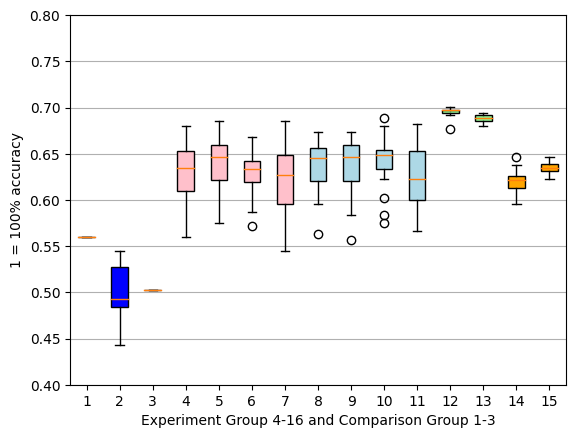

In [ ]:
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb1_odata_pop", "gb1_odata_noP", "xg1_odata_pop", "xg1_odata_noP", \
           "gb2_odata_pop", "gb2_odata_noP", "xg2_odata_pop", "xg2_odata_noP",\
           "baye_odata_pop", "baye_odata_noP", "svm_odata_pop", "svm_odata_noP"]

# Initialize empty lists
acc_w_gb_pop, acc_w_gb_noP, acc_w_xg_pop, acc_w_xg_noP, \
acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2, \
acc_w_baye_pop, acc_w_baye_noP,\
acc_w_svm_pop, acc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_w_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_w_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_w_baye_pop = read_csv_file(acc_w_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_w_baye_noP = read_csv_file(acc_w_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb1" in folder:
        if "pop" in folder:
            acc_w_gb_pop = read_csv_file(acc_w_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP = read_csv_file(acc_w_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg1" in folder:
        if "pop" in folder:
            acc_w_xg_pop = read_csv_file(acc_w_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP = read_csv_file(acc_w_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb2" in folder:
        if "pop" in folder:
            acc_w_gb_pop2 = read_csv_file(acc_w_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP2 = read_csv_file(acc_w_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg2" in folder:
        if "pop" in folder:
            acc_w_xg_pop2 = read_csv_file(acc_w_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP2 = read_csv_file(acc_w_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_w_svm_pop = read_csv_file(acc_w_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_w_svm_noP = read_csv_file(acc_w_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_w_gb_pop), len(acc_w_gb_noP), len(acc_w_xg_pop), len(acc_w_xg_noP)
    , len(acc_w_baye_pop), len(acc_w_baye_noP), len(acc_w_svm_pop), len(acc_w_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_w_dy_prior_loco, acc_w_dy_stratified_loco, acc_w_dy_uni_loco,
    acc_w_gb_pop,acc_w_gb_noP,acc_w_gb_pop2, acc_w_gb_noP2, \
        acc_w_xg_pop,acc_w_xg_noP,acc_w_xg_pop2, acc_w_xg_noP2,
        acc_w_baye_pop,acc_w_baye_noP,acc_w_svm_pop,acc_w_svm_noP]#,acc_w_nn_pop,acc_w_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.8)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}acc_w_loco.png")

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


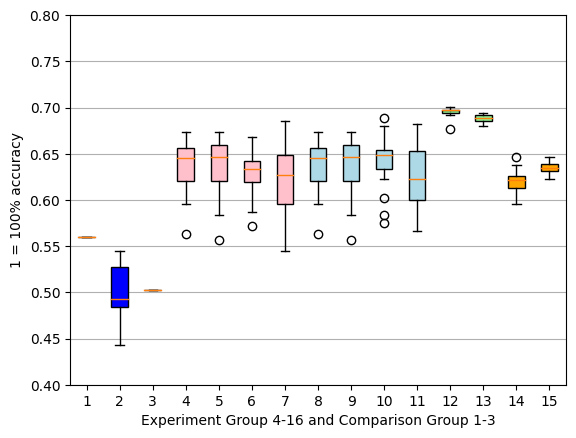

In [ ]:
#Compare with S/noS folders

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb_odata_pop_noS", "gb_odata_noP_noS", "xg_odata_pop_noS", "xg_odata_noP_noS", \
           "gb_odata_pop", "gb_odata_noP", "xg_odata_pop", "xg_odata_noP",\
           "baye_odata_pop", "baye_odata_noP", "svm_odata_pop", "svm_odata_noP"]

# Initialize empty lists
acc_w_gb_pop, acc_w_gb_noP, acc_w_xg_pop, acc_w_xg_noP, \
acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2, \
acc_w_baye_pop, acc_w_baye_noP,\
acc_w_svm_pop, acc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_w_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_w_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_w_baye_pop = read_csv_file(acc_w_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_w_baye_noP = read_csv_file(acc_w_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb" and "noS" in folder:
        if "pop" in folder:
            acc_w_gb_pop = read_csv_file(acc_w_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP = read_csv_file(acc_w_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif folder == "xg_odata_pop_noS":
        print('Found xg_odata_pop_noS')
        acc_w_xg_pop = read_csv_file(acc_w_file_path)
        auc_xg_pop = read_csv_file(auc_file_path)
    elif folder == "xg_odata_noP_noS":
        print('Found xg_odata_noP_noS')
        acc_w_xg_noP = read_csv_file(acc_w_file_path)
        auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb" in folder:
        if "pop" in folder:
            acc_w_gb_pop2 = read_csv_file(acc_w_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP2 = read_csv_file(acc_w_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg" in folder:
        if "pop" in folder:
            acc_w_xg_pop2 = read_csv_file(acc_w_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP2 = read_csv_file(acc_w_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_w_svm_pop = read_csv_file(acc_w_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_w_svm_noP = read_csv_file(acc_w_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)

acc_w_xg_pop = read_csv_file(f"{base}xg_odata_pop_noS/acc_w_all.csv")
auc_xg_pop = read_csv_file(f"{base}xg_odata_pop_noS/auc_all.csv")
acc_w_xg_noP = read_csv_file(f"{base}xg_odata_noP_noS/acc_w_all.csv")
auc_xg_noP = read_csv_file(f"{base}xg_odata_noP_noS/auc_all.csv")

# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_w_gb_pop), len(acc_w_gb_noP), len(acc_w_xg_pop), len(acc_w_xg_noP)
    , len(acc_w_baye_pop), len(acc_w_baye_noP), len(acc_w_svm_pop), len(acc_w_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_w_dy_prior_loco, acc_w_dy_stratified_loco, acc_w_dy_uni_loco,
    acc_w_gb_pop,acc_w_gb_noP,acc_w_gb_pop2,acc_w_gb_noP2,\
         acc_w_xg_pop,acc_w_xg_noP, acc_w_xg_pop2, acc_w_xg_noP2,
        acc_w_baye_pop,acc_w_baye_noP,acc_w_svm_pop,acc_w_svm_noP]#,acc_w_nn_pop,acc_w_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.8)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}acc_w_loco_SnoS.png")

##### Average acc/whole auc

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


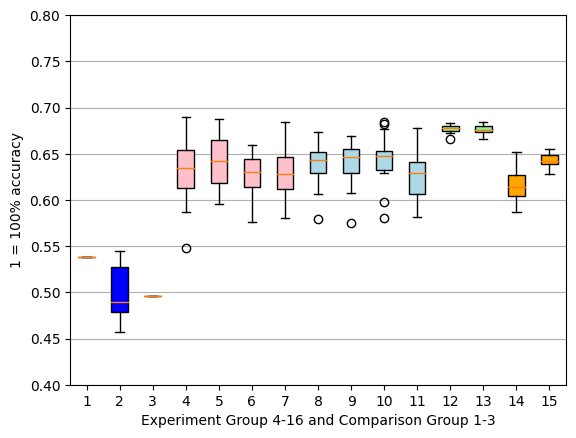

In [ ]:
# Take acc_all instead of acc_all
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb1_odata_pop", "gb1_odata_noP", "gb2_odata_pop", "gb2_odata_noP", \
           "xg1_odata_pop", "xg1_odata_noP", "xg2_odata_pop", "xg2_odata_noP",\
           "baye_odata_pop", "baye_odata_noP", "svm_odata_pop", "svm_odata_noP"]

# Initialize empty lists
acc_gb_pop, acc_gb_noP, acc_xg_pop, acc_xg_noP, \
acc_gb_pop2, acc_gb_noP2, acc_xg_pop2, acc_xg_noP2, \
acc_baye_pop, acc_baye_noP,\
acc_svm_pop, acc_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_svm_pop, auc_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_baye_pop = read_csv_file(acc_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_baye_noP = read_csv_file(acc_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb1" in folder:
        if "pop" in folder:
            acc_gb_pop = read_csv_file(acc_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_gb_noP = read_csv_file(acc_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg1" in folder:
        if "pop" in folder:
            acc_xg_pop = read_csv_file(acc_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_xg_noP = read_csv_file(acc_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb2" in folder:
        if "pop" in folder:
            acc_gb_pop2 = read_csv_file(acc_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_gb_noP2 = read_csv_file(acc_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg2" in folder:
        if "pop" in folder:
            acc_xg_pop2 = read_csv_file(acc_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_xg_noP2 = read_csv_file(acc_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_svm_pop = read_csv_file(acc_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_svm_noP = read_csv_file(acc_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_gb_pop), len(acc_gb_noP), len(acc_xg_pop), len(acc_xg_noP)
    , len(acc_baye_pop), len(acc_baye_noP), len(acc_svm_pop), len(acc_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_dy_prior_loco, acc_dy_stratified_loco, acc_dy_uni_loco,
    acc_gb_pop,acc_gb_noP,acc_gb_pop2, acc_gb_noP2, \
        acc_xg_pop,acc_xg_noP,acc_xg_pop2, acc_xg_noP2,
        acc_baye_pop,acc_baye_noP,acc_svm_pop,acc_svm_noP]#,acc_nn_pop,acc_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.8)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Average accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}acc_loco.png")

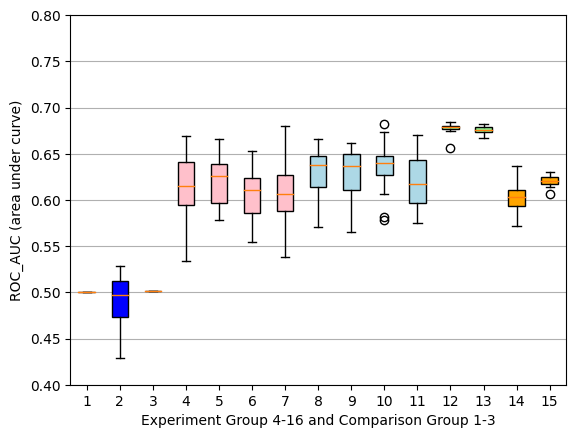

In [ ]:
# Plotting
box_plot_data=[auc_dy_prior_loco, auc_dy_stratified_loco, auc_dy_uni_loco,
    auc_gb_pop,auc_gb_noP,auc_gb_pop2, auc_gb_noP2, \
        auc_xg_pop,auc_xg_noP,auc_xg_pop2, auc_xg_noP2,
        auc_baye_pop,auc_baye_noP,auc_svm_pop,auc_svm_noP]#,auc_nn_pop,auc_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.8)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Average auc score')
plt.ylabel('ROC_AUC (area under curve)')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}auc_loco.png")

##### Whole acc - k

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


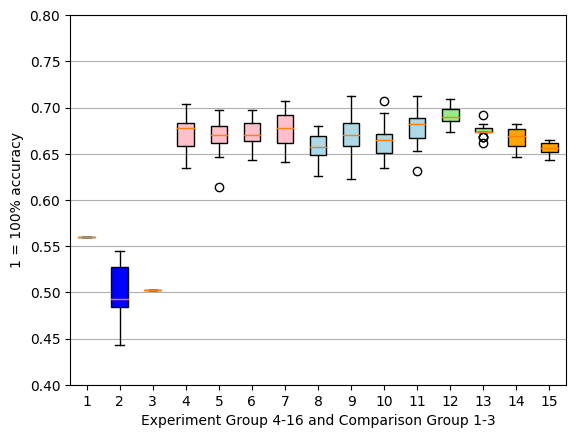

In [ ]:
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb_odata_pop_k_noS", "gb_odata_noP_k_noS", "xg_odata_pop_k_noS", "xg_odata_noP_k_noS", \
           "gb_odata_pop_k", "gb_odata_noP_k", "xg_odata_pop_k", "xg_odata_noP_k",\
           "baye_odata_pop_k", "baye_odata_noP_k", "svm_odata_pop_k", "svm_odata_noP_k"]

# Initialize empty lists
acc_w_gb_pop, acc_w_gb_noP, acc_w_xg_pop, acc_w_xg_noP, \
acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2, \
acc_w_baye_pop, acc_w_baye_noP,\
acc_w_svm_pop, acc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_w_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_w_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_w_baye_pop = read_csv_file(acc_w_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_w_baye_noP = read_csv_file(acc_w_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb" in folder and "noS" in folder:
        if "pop" in folder:
            acc_w_gb_pop = read_csv_file(acc_w_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP = read_csv_file(acc_w_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg" in folder and "noS" in folder:
        if "pop" in folder:
            acc_w_xg_pop = read_csv_file(acc_w_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP = read_csv_file(acc_w_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb" in folder:
        if "pop" in folder:
            acc_w_gb_pop2 = read_csv_file(acc_w_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP2 = read_csv_file(acc_w_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg" in folder:
        if "pop" in folder:
            acc_w_xg_pop2 = read_csv_file(acc_w_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP2 = read_csv_file(acc_w_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_w_svm_pop = read_csv_file(acc_w_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_w_svm_noP = read_csv_file(acc_w_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_w_gb_pop), len(acc_w_gb_noP), len(acc_w_xg_pop), len(acc_w_xg_noP)
    , len(acc_w_baye_pop), len(acc_w_baye_noP), len(acc_w_svm_pop), len(acc_w_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_w_dy_prior_loco, acc_w_dy_stratified_loco, acc_w_dy_uni_loco,
    acc_w_gb_pop,acc_w_gb_noP,acc_w_gb_pop2, acc_w_gb_noP2, \
        acc_w_xg_pop,acc_w_xg_noP,acc_w_xg_pop2,acc_w_xg_noP2,
        acc_w_baye_pop,acc_w_baye_noP,acc_w_svm_pop,acc_w_svm_noP]#,acc_w_nn_pop,acc_w_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.8)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}acc_w_odata_k.png")

##### Average acc/whole auc - k

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


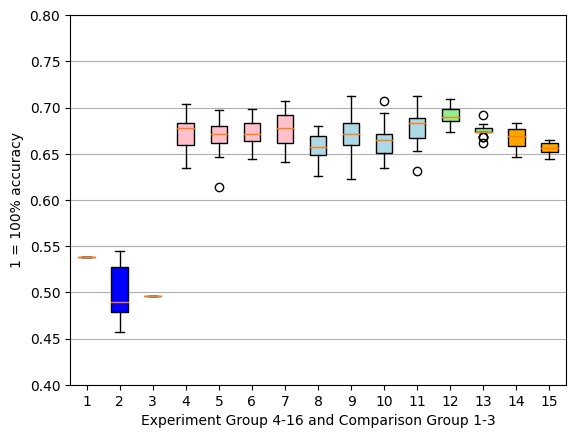

In [ ]:
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb_odata_pop_k_noS", "gb_odata_noP_k_noS", "xg_odata_pop_k_noS", "xg_odata_noP_k_noS", \
           "gb_odata_pop_k", "gb_odata_noP_k", "xg_odata_pop_k", "xg_odata_noP_k",\
           "baye_odata_pop_k", "baye_odata_noP_k", "svm_odata_pop_k", "svm_odata_noP_k"]

# Initialize empty lists
acc_gb_pop, acc_gb_noP, acc_xg_pop, acc_xg_noP, \
acc_gb_pop2, acc_gb_noP2, acc_xg_pop2, acc_xg_noP2, \
acc_baye_pop, acc_baye_noP,\
acc_svm_pop, acc_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_baye_pop = read_csv_file(acc_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_baye_noP = read_csv_file(acc_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb" in folder and "noS" in folder:
        if "pop" in folder:
            acc_gb_pop = read_csv_file(acc_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_gb_noP = read_csv_file(acc_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg" in folder and "noS" in folder:
        if "pop" in folder:
            acc_xg_pop = read_csv_file(acc_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_xg_noP = read_csv_file(acc_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb" in folder:
        if "pop" in folder:
            acc_gb_pop2 = read_csv_file(acc_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_gb_noP2 = read_csv_file(acc_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg" in folder:
        if "pop" in folder:
            acc_xg_pop2 = read_csv_file(acc_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_xg_noP2 = read_csv_file(acc_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_svm_pop = read_csv_file(acc_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_svm_noP = read_csv_file(acc_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_gb_pop), len(acc_gb_noP), len(acc_xg_pop), len(acc_xg_noP)
    , len(acc_baye_pop), len(acc_baye_noP), len(acc_svm_pop), len(acc_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))
# print(acc_xg_pop2,acc_xg_noP2)
# Plotting
box_plot_data=[acc_dy_prior_loco, acc_dy_stratified_loco, acc_dy_uni_loco,
    acc_gb_pop,acc_gb_noP,acc_gb_pop2, acc_gb_noP2, \
        acc_xg_pop,acc_xg_noP,acc_xg_pop2,acc_xg_noP2,
        acc_baye_pop,acc_baye_noP,acc_svm_pop,acc_svm_noP]#,acc_nn_pop,acc_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.8)
# ax1.set_ylim(0.4, 0.8)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}acc_odata_k.png")

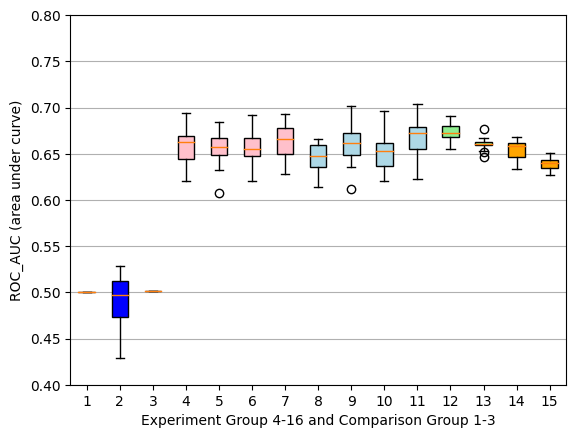

In [ ]:
# Plotting
box_plot_data=[auc_dy_prior_loco, auc_dy_stratified_loco, auc_dy_uni_loco,
    auc_gb_pop,auc_gb_noP,auc_gb_pop2, auc_gb_noP2, \
        auc_xg_pop,auc_xg_noP,auc_xg_pop2, auc_xg_noP2,
        auc_baye_pop,auc_baye_noP,auc_svm_pop,auc_svm_noP]#,auc_nn_pop,auc_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.8)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Average auc score')
plt.ylabel('ROC_AUC (area under curve)')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}auc_odata_k.png")

#### GKB data

##### Whole acc/Read results from repeated training for xg,gb,svm and bayes model

20 20 20 20 20 20 20 20 20 20 20 20


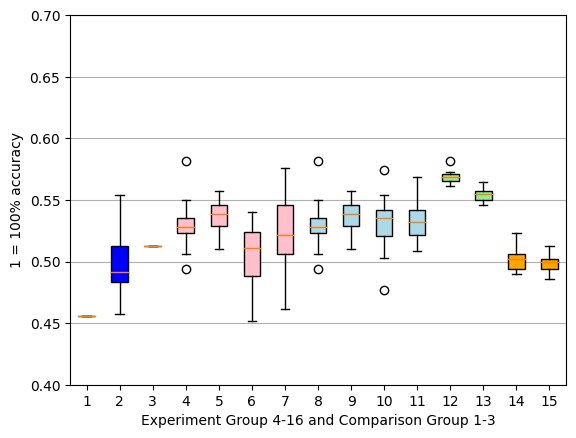

In [ ]:
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb_gkb_pop_noS", "gb_gkb_noP_noS", "gb_gkb_pop", "gb_gkb_noP", \
           "xg_gkb_pop_noS", "xg_gkb_noP_noS", "xg_gkb_pop", "xg_gkb_noP",\
           "baye_gkb_pop", "baye_gkb_noP", "svm_gkb_pop", "svm_gkb_noP"]

# Initialize empty lists
acc_w_gb_pop, acc_w_gb_noP, acc_w_xg_pop, acc_w_xg_noP, \
acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2, \
acc_w_baye_pop, acc_w_baye_noP,\
acc_w_svm_pop, acc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_w_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_w_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_w_baye_pop = read_csv_file(acc_w_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_w_baye_noP = read_csv_file(acc_w_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb" and "noS" in folder:
        if "pop" in folder:
            acc_w_gb_pop = read_csv_file(acc_w_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP = read_csv_file(acc_w_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg" and "noS" in folder:
        if "pop" in folder:
            acc_w_xg_pop = read_csv_file(acc_w_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP = read_csv_file(acc_w_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb" in folder:
        if "pop" in folder:
            acc_w_gb_pop2 = read_csv_file(acc_w_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP2 = read_csv_file(acc_w_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg" in folder:
        if "pop" in folder:
            acc_w_xg_pop2 = read_csv_file(acc_w_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP2 = read_csv_file(acc_w_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_w_svm_pop = read_csv_file(acc_w_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_w_svm_noP = read_csv_file(acc_w_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)

acc_w_xg_pop = read_csv_file(f"{base}xg_gkb_pop_noS/acc_w_all.csv")
auc_xg_pop = read_csv_file(f"{base}xg_gkb_pop_noS/auc_all.csv")
acc_w_xg_noP = read_csv_file(f"{base}xg_gkb_noP_noS/acc_w_all.csv")
auc_xg_noP = read_csv_file(f"{base}xg_gkb_noP_noS/auc_all.csv")

# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_w_gb_pop), len(acc_w_gb_noP), len(acc_w_gb_pop2), len(acc_w_gb_noP2),
 len(acc_w_xg_pop), len(acc_w_xg_noP),len(acc_w_xg_pop2), len(acc_w_xg_noP2)
    , len(acc_w_baye_pop), len(acc_w_baye_noP), len(acc_w_svm_pop), len(acc_w_svm_noP))

# Plotting
box_plot_data=[acc_w_dy_prior_loco2, acc_w_dy_stratified_loco2, acc_w_dy_uni_loco2,
    acc_w_gb_pop,acc_w_gb_noP,acc_w_gb_pop2,acc_w_gb_noP2, \
        acc_w_xg_pop,acc_w_xg_noP,acc_w_xg_pop2,acc_w_xg_noP2,
        acc_w_baye_pop,acc_w_baye_noP,acc_w_svm_pop,acc_w_svm_noP]#,acc_w_nn_pop,acc_w_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.7)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}acc_w_loco_gkb.png")

##### Whole auc

20 20 20 20
20 20 20 20 20 20 20 20


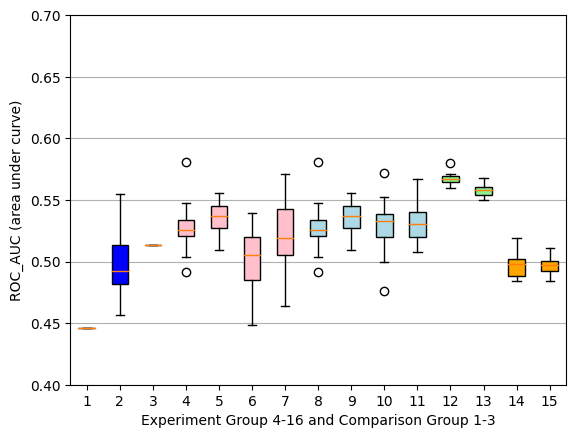

In [ ]:
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP))
print(len(auc_gb_pop2), len(auc_gb_noP2), len(auc_xg_pop2), len(auc_xg_noP2)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))
# Plotting
box_plot_data=[auc_dy_prior_loco2, auc_dy_stratified_loco2, auc_dy_uni_loco2,
    auc_gb_pop,auc_gb_noP,auc_gb_pop2,auc_gb_noP2,\
         auc_xg_pop,auc_xg_noP,auc_xg_pop2,auc_xg_noP2,
        auc_baye_pop,auc_baye_noP,auc_svm_pop,auc_svm_noP]#,auc_nn_pop,auc_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.7)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('ROC_AUC (area under curve)')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}auc_loco_gkb.png")

##### Average acc

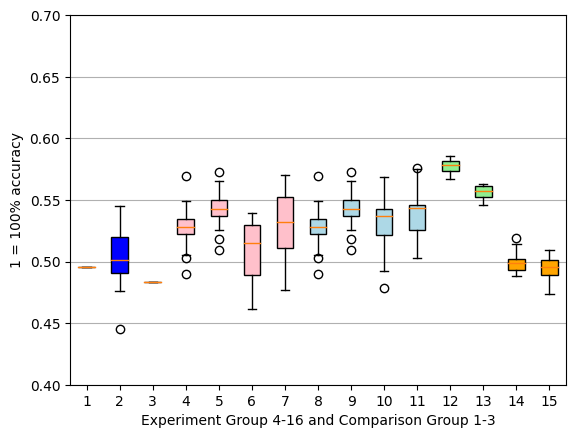

In [ ]:
# Take acc_all instead of acc_all
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb_gkb_pop_noS", "gb_gkb_noP_noS","gb_gkb_pop", "gb_gkb_noP", \
           "xg_gkb_pop_noS", "xg_gkb_noP_noS",  "xg_gkb_pop", "xg_gkb_noP",\
           "baye_gkb_pop", "baye_gkb_noP", "svm_gkb_pop", "svm_gkb_noP"]

# Initialize empty lists
acc_gb_pop, acc_gb_noP, acc_xg_pop, acc_xg_noP, \
acc_gb_pop2, acc_gb_noP2, acc_xg_pop2, acc_xg_noP2, \
acc_baye_pop, acc_baye_noP,\
acc_svm_pop, acc_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_baye_pop = read_csv_file(acc_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_baye_noP = read_csv_file(acc_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb" and "noS" in folder:
        if "pop" in folder:
            acc_gb_pop = read_csv_file(acc_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_gb_noP = read_csv_file(acc_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg" and "noS" in folder:
        if "pop" in folder:
            acc_xg_pop = read_csv_file(acc_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_xg_noP = read_csv_file(acc_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb" in folder:
        if "pop" in folder:
            acc_gb_pop2 = read_csv_file(acc_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_gb_noP2 = read_csv_file(acc_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg" in folder:
        if "pop" in folder:
            acc_xg_pop2 = read_csv_file(acc_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_xg_noP2 = read_csv_file(acc_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_svm_pop = read_csv_file(acc_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_svm_noP = read_csv_file(acc_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)

acc_xg_pop = read_csv_file(f"{base}xg_gkb_pop_noS/acc_all.csv")
auc_xg_pop = read_csv_file(f"{base}xg_gkb_pop_noS/auc_all.csv")
acc_xg_noP = read_csv_file(f"{base}xg_gkb_noP_noS/acc_all.csv")
auc_xg_noP = read_csv_file(f"{base}xg_gkb_noP_noS/auc_all.csv")

# Plotting
box_plot_data=[acc_dy_prior_loco2, acc_dy_stratified_loco2, acc_dy_uni_loco2,
    acc_gb_pop,acc_gb_noP,acc_gb_pop2, acc_gb_noP2, \
        acc_xg_pop,acc_xg_noP,acc_xg_pop2, acc_xg_noP2,
        acc_baye_pop,acc_baye_noP,acc_svm_pop,acc_svm_noP]#,acc_nn_pop,acc_nn_noP]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.7)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop,nn_noP"
#0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP"
plt.show()
fig.savefig(f"{base}acc_loco_gkb.png")

##### Whole acc - k/Read results from repeated training for xg,gb,svm and bayes model

20 20 20 20 20 20 20 20 20 20 20 20


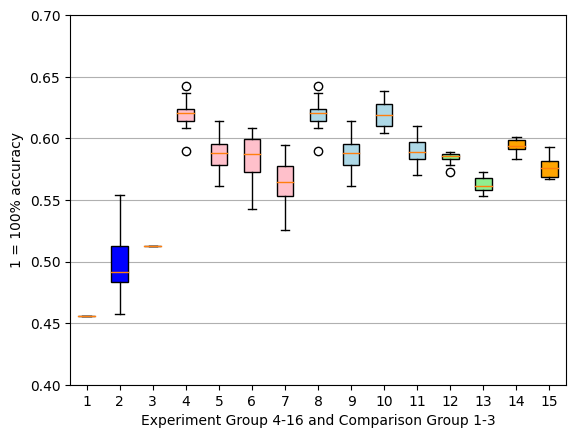

In [ ]:
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb_gkb_pop_k_noS", "gb_gkb_noP_k_noS", "gb_gkb_pop_k", "gb_gkb_noP_k", \
           "xg_gkb_pop_k_noS", "xg_gkb_pop_k", "xg_gkb_noP_k_noS", "xg_gkb_noP_k",\
           "baye_gkb_pop_k", "baye_gkb_noP_k", "svm_gkb_pop_k", "svm_gkb_noP_k"]
           #"xg_gkb_noP_k_noS", "xg_gkb_noP_k"

# Initialize empty lists
acc_w_gb_pop_k, acc_w_gb_noP_k, acc_w_xg_pop_k, acc_w_xg_noP_k, \
acc_w_gb_pop_k2, acc_w_gb_noP_k2, acc_w_xg_pop_k2, acc_w_xg_noP_k2, \
acc_w_baye_pop_k, acc_w_baye_noP_k,\
acc_w_svm_pop_k, acc_w_svm_noP_k= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop_k, auc_gb_noP_k, auc_xg_pop_k, auc_xg_noP_k, \
auc_gb_pop_k2, auc_gb_noP_k2, auc_xg_pop_k2, auc_xg_noP_k2,\
auc_baye_pop_k, auc_baye_noP_k,\
auc_w_svm_pop_k, auc_w_svm_noP_k= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_w_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_w_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_w_baye_pop_k = read_csv_file(acc_w_file_path)
            auc_baye_pop_k = read_csv_file(auc_file_path)
        else:
            acc_w_baye_noP_k = read_csv_file(acc_w_file_path)
            auc_baye_noP_k = read_csv_file(auc_file_path)
    elif "gb" and "noS" in folder:
        if "pop" in folder:
            acc_w_gb_pop_k = read_csv_file(acc_w_file_path)
            auc_gb_pop_k = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP_k = read_csv_file(acc_w_file_path)
            auc_gb_noP_k = read_csv_file(auc_file_path)
    elif "xg" and "noS" in folder: # Cannot read the file?
        if "pop" in folder:
            acc_w_xg_pop_k = read_csv_file(acc_w_file_path)
            auc_xg_pop_k = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP_k = read_csv_file(acc_w_file_path)
            auc_xg_noP_k = read_csv_file(auc_file_path)
    elif "gb" in folder:
        if "pop" in folder:
            acc_w_gb_pop_k2 = read_csv_file(acc_w_file_path)
            auc_gb_pop_k2 = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP_k2 = read_csv_file(acc_w_file_path)
            auc_gb_noP_k2 = read_csv_file(auc_file_path)
    elif "xg" in folder:
        if "pop" in folder:
            acc_w_xg_pop_k2 = read_csv_file(acc_w_file_path)
            auc_xg_pop_k2 = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP_k2 = read_csv_file(acc_w_file_path)
            auc_xg_noP_k2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_w_svm_pop_k = read_csv_file(acc_w_file_path)
            auc_svm_pop_k = read_csv_file(auc_file_path)
        else:
            acc_w_svm_noP_k = read_csv_file(acc_w_file_path)
            auc_svm_noP_k = read_csv_file(auc_file_path)

acc_w_xg_pop_k = read_csv_file(f"{base}xg_gkb_pop_k_noS/acc_w_all.csv")
auc_xg_pop_k = read_csv_file(f"{base}xg_gkb_pop_k_noS/auc_all.csv")

acc_w_xg_noP_k = read_csv_file(f"{base}xg_gkb_noP_k_noS/acc_w_all.csv")
auc_xg_noP_k = read_csv_file(f"{base}xg_gkb_noP_k_noS/auc_all.csv")

# acc_w_xg_noP_k2 = read_csv_file(f"{base}xg_gkb_noP_k/acc_w_all.csv")
# auc_xg_noP_k2 = read_csv_file(f"{base}xg_gkb_noP_k/auc_all.csv")

# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_w_gb_pop_k), len(acc_w_gb_noP_k), len(acc_w_gb_pop_k2), len(acc_w_gb_noP_k2),
 len(acc_w_xg_pop_k), len(acc_w_xg_noP_k),len(acc_w_xg_pop_k2), len(acc_w_xg_noP_k2)
    , len(acc_w_baye_pop_k), len(acc_w_baye_noP_k), len(acc_w_svm_pop_k), len(acc_w_svm_noP_k))

# Plotting
box_plot_data=[acc_w_dy_prior_loco2, acc_w_dy_stratified_loco2, acc_w_dy_uni_loco2,
    acc_w_gb_pop_k,acc_w_gb_noP_k,acc_w_gb_pop_k2,acc_w_gb_noP_k2, \
        acc_w_xg_pop_k,acc_w_xg_noP_k,acc_w_xg_pop_k2,acc_w_xg_noP_k2,
        acc_w_baye_pop_k,acc_w_baye_noP_k,acc_w_svm_pop_k,acc_w_svm_noP_k]#,acc_w_nn_pop_k,acc_w_nn_noP_k]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.7)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop_k,nn_noP_k"
#0-11 Boxes: gb_pop_k,gb_noP_k,gb_pop_k2,gb_noP_k2,xg_pop_k,xg_noP_k,xg_pop_k2,\n\xg_noP_k2,baye_pop_k,baye_noP_k,svm_pop_k,svm_noP_k"
plt.show()
fig.savefig(f"{base}acc_w_loco_gkb_k.png")

##### Whole auc - k

20 20 20 20
20 20 20 20 20 20 20 20


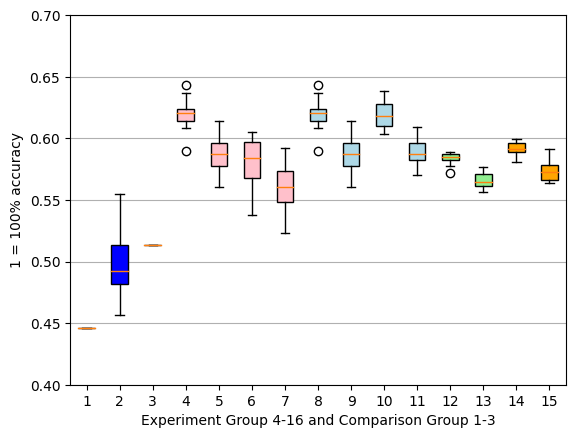

In [ ]:
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(auc_gb_pop_k), len(auc_gb_noP_k), len(auc_xg_pop_k), len(auc_xg_noP_k))
print(len(auc_gb_pop_k2), len(auc_gb_noP_k2), len(auc_xg_pop_k2), len(auc_xg_noP_k2)
    , len(auc_baye_pop_k), len(auc_baye_noP_k), len(auc_svm_pop_k), len(auc_svm_noP_k))
# Plotting
box_plot_data=[auc_dy_prior_loco2, auc_dy_stratified_loco2, auc_dy_uni_loco2,
    auc_gb_pop_k,auc_gb_noP_k,auc_gb_pop_k2,auc_gb_noP_k2,\
         auc_xg_pop_k,auc_xg_noP_k,auc_xg_pop_k2,auc_xg_noP_k2,
        auc_baye_pop_k,auc_baye_noP_k,auc_svm_pop_k,auc_svm_noP_k]#,auc_nn_pop_k,auc_nn_noP_k]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.7)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop_k,nn_noP_k"
#0-11 Boxes: gb_pop_k,gb_noP_k,gb_pop_k2,gb_noP_k2,xg_pop_k,xg_noP_k,xg_pop_k2,\n\xg_noP_k2,baye_pop_k,baye_noP_k,svm_pop_k,svm_noP_k"
plt.show()
fig.savefig(f"{base}auc_loco_gkb_k.png")

##### Average acc - k

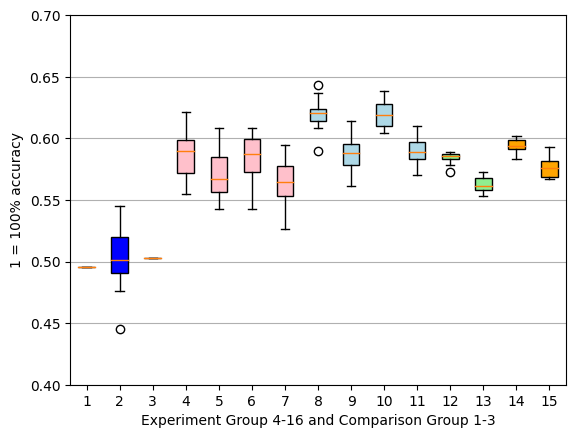

In [ ]:
# Take acc_all instead of acc_all
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb_gkb_pop_k_noS", "gb_gkb_noP_k_noS", "gb_gkb_pop_k", "gb_gkb_noP_k",\
           "xg_gkb_pop_k_noS", "xg_gkb_pop_k", "xg_gkb_noP_k_noS", "xg_gkb_noP_k",\
           "baye_gkb_pop_k", "baye_gkb_noP_k", "svm_gkb_pop_k", "svm_gkb_noP_k"]#

# Initialize empty lists
acc_gb_pop_k, acc_gb_noP_k, acc_xg_pop_k, acc_xg_noP_k, \
acc_gb_pop_k2, acc_gb_noP_k2, acc_xg_pop_k2, acc_xg_noP_k2, \
acc_baye_pop_k, acc_baye_noP_k,\
acc_svm_pop_k, acc_svm_noP_k= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop_k, auc_gb_noP_k, auc_xg_pop_k, auc_xg_noP_k, \
auc_gb_pop_k2, auc_gb_noP_k2, auc_xg_pop_k2, auc_xg_noP_k2,\
auc_baye_pop_k, auc_baye_noP_k,\
auc_w_svm_pop_k, auc_w_svm_noP_k= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_baye_pop_k = read_csv_file(acc_file_path)
            auc_baye_pop_k = read_csv_file(auc_file_path)
        else:
            acc_baye_noP_k = read_csv_file(acc_file_path)
            auc_baye_noP_k = read_csv_file(auc_file_path)
    elif "gb" in folder and "noS" in folder:
        if "pop" in folder:
            acc_gb_pop_k = read_csv_file(acc_file_path)
            auc_gb_pop_k = read_csv_file(auc_file_path)
        else:
            acc_gb_noP_k = read_csv_file(acc_file_path)
            auc_gb_noP_k = read_csv_file(auc_file_path)
    elif "xg" in folder and "noS" in folder:
        if "pop" in folder:
            acc_xg_pop_k = read_csv_file(acc_file_path)
            auc_xg_pop_k = read_csv_file(auc_file_path)
        else:
            acc_xg_noP_k = read_csv_file(acc_file_path)
            auc_xg_noP_k = read_csv_file(auc_file_path)
    elif "gb" in folder:
        if "pop" in folder:
            acc_gb_pop_k2 = read_csv_file(acc_file_path)
            auc_gb_pop_k2 = read_csv_file(auc_file_path)
        else:
            acc_gb_noP_k2 = read_csv_file(acc_file_path)
            auc_gb_noP_k2 = read_csv_file(auc_file_path)
    elif "xg" in folder:
        if "pop" in folder:
            acc_xg_pop_k2 = read_csv_file(acc_file_path)
            auc_xg_pop_k2 = read_csv_file(auc_file_path)
        else:
            acc_xg_noP_k2 = read_csv_file(acc_file_path)
            auc_xg_noP_k2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_svm_pop_k = read_csv_file(acc_file_path)
            auc_svm_pop_k = read_csv_file(auc_file_path)
        else:
            acc_svm_noP_k = read_csv_file(acc_file_path)
            auc_svm_noP_k = read_csv_file(auc_file_path)

# acc_xg_pop_k = read_csv_file(f"{base}xg_gkb_pop_k_noS/acc_all.csv")
# auc_xg_pop_k = read_csv_file(f"{base}xg_gkb_pop_k_noS/auc_all.csv")
# acc_xg_noP_k = read_csv_file(f"{base}xg_gkb_noP_k_noS/acc_all.csv")
# auc_xg_noP_k = read_csv_file(f"{base}xg_gkb_noP_k_noS/auc_all.csv")

# acc_xg_pop_k2 = read_csv_file(f"{base}xg_gkb_pop_k/acc_all.csv")
# print(len(acc_xg_pop_k2))
# print(acc_xg_pop_k2)

# Plotting
box_plot_data=[acc_dy_prior_loco2, acc_dy_stratified_loco2, acc_dy_uni_loco2,
    acc_gb_pop_k,acc_gb_noP_k,acc_gb_pop_k2, acc_gb_noP_k2, \
        acc_xg_pop_k,acc_xg_noP_k,acc_xg_pop_k2, acc_xg_noP_k2,
        acc_baye_pop_k,acc_baye_noP_k,acc_svm_pop_k,acc_svm_noP_k]#,acc_nn_pop_k,acc_nn_noP_k]
max_n = len(box_plot_data)+1
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(1,max_n),vert=True,patch_artist=True)
ax1.set_ylim(0.4, 0.7)
# fill with colors
colors = ['b','b','b','pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
# plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel(f'Experiment Group 4-{max_n} and Comparison Group 1-3')#,nn_pop_k,nn_noP_k"
#0-11 Boxes: gb_pop_k,gb_noP_k,gb_pop_k2,gb_noP_k2,xg_pop_k,xg_noP_k,xg_pop_k2,\n\xg_noP_k2,baye_pop_k,baye_noP_k,svm_pop_k,svm_noP_k"
plt.show()
fig.savefig(f"{base}acc_loco_gkb_k.png")